In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math

#Set colour map for all plots
cmap = plt.get_cmap("tab10")

## Epidemic Model

In [3]:
#Epidemiological model
def run_SIR(Graph, beta, gamma, max_time):
    #Copy graph so no changes are made to original graph 
    G = Graph.copy()
    N = G.number_of_nodes()
    
    #Set infection status to susceptible for all nodes
    nx.set_node_attributes(G, 'S', 'status')
    
    #Randomly infect one person in the population
    patient_zero = np.random.randint(0,N-1)
    G.nodes[patient_zero]['status'] = 'I'
    
    #Initialise time at zero
    t = 0
    
    #Initialise arrays for storing number of nodes in each state
    T = np.arange(0,max_time)
    S = np.zeros(max_time)
    I = np.zeros(max_time)
    R = np.zeros(max_time)
    
    num_inf = 1
    while t < max_time:
        if num_inf > 0: 
            #Arrays for storing the indices of nodes that will have their state updated at the end of the timestep
            update_to_I = np.zeros(N)
            update_to_R = np.zeros(N)

            num_sus = 0 
            num_inf = 0
            for n in G.nodes:
                if G.nodes[n]['status'] == 'S':
                    num_sus +=1
                    #Count how many infected neighbours
                    i = 0
                    for neigh in G.neighbors(n):
                        if G.nodes[neigh]['status'] == 'I':
                            i += 1
                            
                    #If it has at least one inf neighbour, see if the node gets infected
                    if i > 0:
                        r = np.random.uniform()
                        inf_prob = 1 - math.exp(-beta*i)
                        if r < inf_prob:
                            update_to_I[n]=1
                elif G.nodes[n]['status'] == 'I':
                    num_inf += 1
                    #Recover with probability gamma
                    r = np.random.uniform()
                    if r < gamma:
                        update_to_R[n] = 1

            #Update all statuses
            for n,i in enumerate(update_to_I):
                if i == 1:
                    G.nodes[n]['status'] = 'I'
            for n,i in enumerate(update_to_R):
                if i == 1:
                    G.nodes[n]['status'] = 'R'

        
        S[t] = num_sus
        I[t] = num_inf
        R[t] = N - num_sus - num_inf
        t += 1
    
    return T, S, I, R, G

## Calculating average clustering coefficient and plots for W-S graphs 

In [49]:
p_list = np.arange(0,1.01,0.01)
N = 50;
k = 6;
num_graphs = 100;
average_cc = np.zeros((len(p_list),1))# average clustering coef list
for idx,p in enumerate(p_list):
    c=0
    for n in np.arange(0, num_graphs):
        # Generate Watts strogatz graph using the networkx random graph generator
        G_temp = nx.random_graphs.watts_strogatz_graph(N,k,p)
        # visualize a network using circular layout
        # nx.draw(G_temp,pos=nx.circular_layout(G_temp), with_labels=False, font_color='w', node_color=node_color, node_size=40)
        
        c += nx.average_clustering(G_temp)
    average_cc[idx] = c/num_graphs

KeyboardInterrupt: 

In [48]:

plt.plot(p_list,average_cc,'o')
plt.ylabel('Global clustering coefficient',fontsize=14)
plt.xlabel('$p$',fontsize=14)
plt.savefig('W-S_gcc.png')

NameError: name 'average_cc' is not defined

## Plots for small number of p values

In [46]:
p_list = [0.15,0.2, 0.3]
N = 100;
k = 10;
max_time = 500
num_sims = 100

R0 = 1.8
gamma=0.2
beta = R0*gamma/k


#Set up arrays for storing outputs
glob_clust = np.zeros(len(p_list)) #Average clustering coefficient
I_array1 = np.zeros((len(p_list), max_time, num_sims))
tot_inf1 = np.zeros((len(p_list), num_sims)) #Total number of infections
graphs={}

for i, p in enumerate(p_list):
    #Generate W-S graph for set value of p
    G_temp = nx.random_graphs.watts_strogatz_graph(N,k,p)
    
    #Calculate the global clustering coefficient
    glob_clust[i] = nx.average_clustering(G_temp)
    
    max_I = 0
    
    #Run SIR model num_sims times
    for j in np.arange(0, num_sims):
        T, S, I, R, G_new = run_SIR(G_temp, beta, gamma, max_time)
        
        if max(I) > max_I:
            #Record graph used in a dictionary
            graphs[i]= G_new
            max_I = max(I)
            
        #Store infection data in arrays
        I_array1[i, :, j] = I
        tot_inf1[i,j] = R[-1]


In [47]:
print(glob_clust)

[0.44441897 0.41469963 0.26680497]


In [36]:
plt.figure(figsize=(8,15))

for i,p in enumerate(p_list):
    G = graphs[i]
    # create empty list for node colors
    node_color = []
    for n in G.nodes:
        if G.nodes[n]['status'] == 'R':
            node_color.append(cmap(3))
        elif G.nodes[n]['status'] == 'S':
            node_color.append(cmap(0))
    fig = plt.subplots()
    #plt.title(f"p = {p},  C ={glob_clust[i]: .2f}",fontsize=16)
    nx.draw(G,pos = nx.spring_layout(G,k=1.5,seed = 2022),
            with_labels=False, font_color='w', node_color=node_color, node_size=40)
    #pos=nx.circular_layout(G_temp)
    #pos = nx.spring_layout(G,k=1.5,seed = 2022)
    plt.savefig(f"inf_network{p}.png")
    

KeyError: 0

<Figure size 576x1080 with 0 Axes>

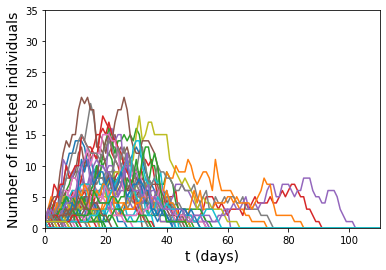

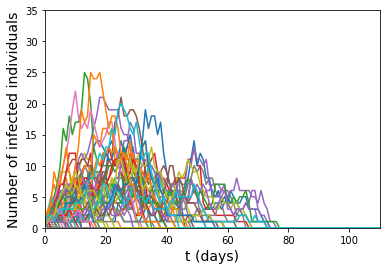

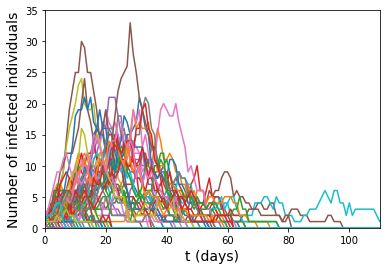

In [31]:
for i,p in enumerate(p_list):

    fig, ax = plt.subplots();
    ax.plot(T,I_array1[i,:,:]);
    ax.set_xlim([0,110]);
    ax.set_ylim([0,35]);
    plt.xlabel("t (days)",fontsize=14);
    plt.ylabel("Number of infected individuals",fontsize=14);
    #plt.title(f"p = {p},  C ={glob_clust[i]: .2f}");
    
    #fig.set_size_inches(12, 8)
    plt.savefig(f"inf_graph{p}.png")

In [336]:
mydata = np.genfromtxt('s50-network1.dat', delimiter=' ')
G1 = nx.from_numpy_matrix(mydata)

mydata = np.genfromtxt('s50-network2.dat', delimiter=' ')
G2 = nx.from_numpy_matrix(mydata)

mydata = np.genfromtxt('s50-network3.dat', delimiter=' ')
G3 = nx.from_numpy_matrix(mydata)

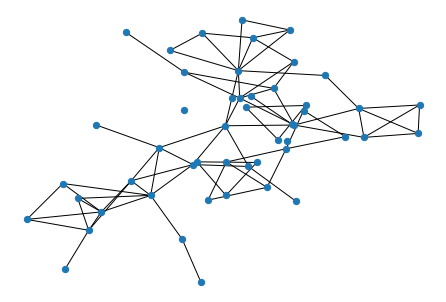

In [337]:
nx.draw(G1, pos = nx.kamada_kawai_layout(G1), node_size=40)

In [342]:
degrees = [d for u,d in G1.degree()]
av_deg1 = np.average(degrees)
av_clust1 = nx.average_clustering(G1)

print(f"G1 has average degree {av_deg1} and global clustering coefficient {av_clust1: .2f}")

G1 has average degree 2.96 and global clustering coefficient  0.49


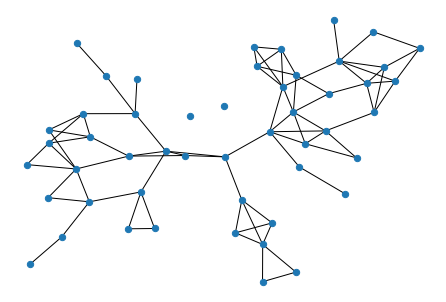

In [338]:
nx.draw(G2, pos = nx.kamada_kawai_layout(G2), node_size=40)

In [343]:
degrees = [d for u,d in G2.degree()]
av_deg2 = np.average(degrees)
av_clust2 = nx.average_clustering(G2)

print(f"G1 has average degree {av_deg2} and global clustering coefficient {av_clust2: .2f}")

G1 has average degree 3.24 and global clustering coefficient  0.39


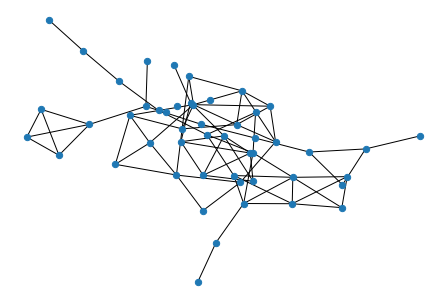

In [344]:
nx.draw(G3, pos = nx.kamada_kawai_layout(G3), node_size=40)

In [345]:
degrees = [d for u,d in G3.degree()]
av_deg3 = np.average(degrees)
av_clust3 = nx.average_clustering(G3)

print(f"G3 has average degree {av_deg3} and global clustering coefficient {av_clust3: .2f}")

G3 has average degree 3.08 and global clustering coefficient  0.44
